### Figure 2: Cell Turnover, Anisomycin Effects, and Placefield Stability Remapping

Note that you must run through `run_placefields.py` for each mouse to check day-to-day alignment of behavioral data before running most of the place field related functions below.

In [1]:
import scipy.stats as sstats
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd


# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import cell_tracking as ct
import er_plot_functions as erp

Set up main figure for plotting

## NRK todo:
0) Match axes for overlap plots
1) Fix color in plots below for overlap. Black and green?
2) remove axes on plots below
3) Add in ANI place field plots

[8.5 6.5]


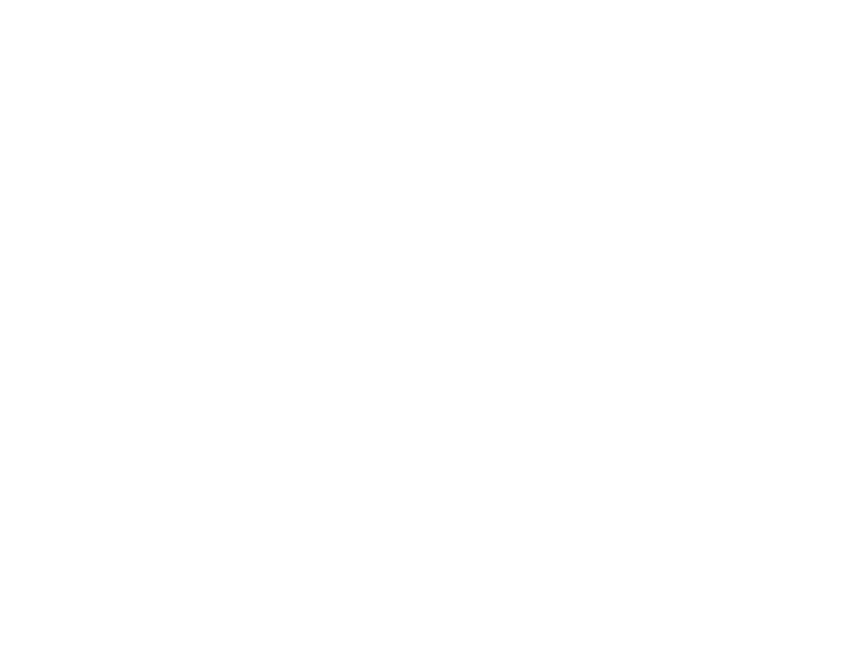

In [2]:
# Set up main figure plotting
%matplotlib ipympl
Fig2 = Fig(num=2, grid=(4, 4), size=(8.5, 6.5), fontsize=6)
print(Fig2.fig.get_size_inches())

[8.5 6.5]


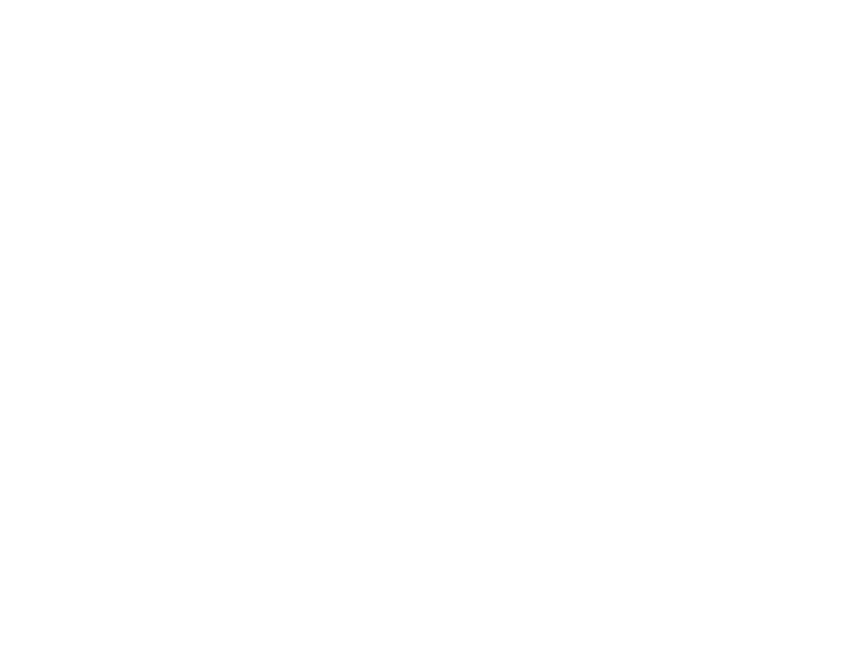

In [3]:
# Set up stats figure
Fig2stats = Fig(num="Figure 2 stats", grid=(4, 4), size=(8.5, 6.5), fontsize=6)
print(Fig2.fig.get_size_inches())
Fig2comb = FigMirror(Fig2, Fig2stats)

Plots #3/4: Cell turnover across days

In [4]:
# Test code for reshaping - want 1st index from 3rd dim folded into 2nd, e.g. combine shock v shock and open v open
# Not currently used, but could be useful if we need to add in "open" v "open" overlaps at some later point, no
# currently included, only "shock" v "shock"
a = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
a[:, :, 1] = a[:, :, 1]*10
print(a)
# So 1, 4, 7, and 20, 50, 80 are same arena, 3, 6, 9 are different
b = np.append(a, np.nan*np.ones_like(a[:, :, 2, None]), axis=2)
c = b.reshape((int(b.shape[0]*2), b.shape[1], int(b.shape[2]/2)), order='F')
print('3rd dim index = 0 after reshaping - should be 1, 4, 7, 20, 50, 80')
print(c[:, :, 0])
print('3rd dim index = 1 after reshaping - should be 3, 6, 9, and nan')
print(c[:, :, 1])
# Ok, so this works - things are grouped appropriately

[[[ 1 20  3]
  [ 4 50  6]
  [ 7 80  9]]

 [[ 1 20  3]
  [ 4 50  6]
  [ 7 80  9]]]
3rd dim index = 0 after reshaping - should be 1, 4, 7, 20, 50, 80
[[ 1.  7. 50.]
 [ 1.  7. 50.]
 [ 4. 20. 80.]
 [ 4. 20. 80.]]
3rd dim index = 1 after reshaping - should be 3, 6, 9, and nan
[[ 3.  9. nan]
 [ 3.  9. nan]
 [ 6. nan nan]
 [ 6. nan nan]]


In [5]:
plot_ind = False

axolap_ctrl = Fig2.subplot(441)
axolap_ani = Fig2.subplot(442)

oratioboth_comb = []
for ax, mice, group_title in zip([axolap_ctrl, axolap_ani], [err.control_mice_good, err.ani_mice_good], 
                                 ["Control", "Anisomycin"]):
    # days = [-1, 0, 4, 1, 2]  # use this to look at change from day 0 to 4hr sesh (good in control arena only)
    days = [-1, 4, 1, 2, 7]  # legit way - use to look at change across all days with 10 min sessions
#     arenas = ['Shock', 'Open']
    arenas = [["Shock", "Shock"], ["Shock", "Open"]]
    oratio1 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratio2 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratioboth = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomin = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomax = np.ones((len(mice), len(days), len(arenas)))*np.nan

    # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
    pathname = err.pathname  # Get plotting folder
    for idm, mouse in enumerate(mice):
        for idd, day in enumerate(days):
            for ida, arena_pair in enumerate(arenas):
                try:
                    _, _, oratioboth[idm, idd, ida], oratiomin[idm, idd, ida], oratiomax[idm, idd, ida] = \
                        pfs.get_overlap(mouse, arena_pair[0], -2, arena_pair[1], day)
                except TypeError:
                    print('Missing reg file for ' + mouse + ' Day ' + str(day) + ' ' + arena)

        if plot_ind:
            fig, ax, hline = er.plot_overlaps(oratio1[idm, :, :], days=days)
            fig.savefig(os.path.join(pathname, 'Cell Overlap ' + group_title + '-' + mouse + '.pdf'))
            plt.close(fig)
    
#     # Now reshape things in oratio both to make plotting easier - see above code block for sanity check - not working
#     temp = np.append(oratioboth, np.nan*np.ones_like(oratioboth[:, :, 2, None]), axis=2)
#     oratioboth_rs = temp.reshape((int(temp.shape[0]*2), temp.shape[1], int(temp.shape[2]/2)), order='F')
    
    _, _ = er.plot_overlaps(oratioboth, days=days, jitter=[-0.05, 0.05], colors = ['b', 'r'], 
                              arenas=['Shock v Shock', 'Shock v Neutral'], ax=ax, markersize=2.0)
    ax.set_title(group_title)
    ax.set_ylabel('Overlap Ratio')

    oratioboth_comb.append(oratioboth)  # Create list with both groups data in it.

Now quantify accelerated change and then slower change (measured by cell overlap) due to ANI administration

In [6]:
# Dump data into dataframe for easy plotting in seaborn afterward...
day_pairs = ['-1_4', '4_1', '1_2', '2_7']
grp_list, dolap_list, day_list = [], [], []
for idg, grp in enumerate(['Ctrl', 'ANI']):
    oratio_use = oratioboth_comb[idg]
    for idd, day_pair in enumerate(day_pairs):
        dolap = oratio_use[:, idd, :].reshape(-1) - oratio_use[:, idd + 1, :].reshape(-1)
        dolap_list.extend(dolap)
        grp_list.extend(len(dolap)*[grp])
        day_list.extend(len(dolap)*[day_pair])

dolap_df = pd.DataFrame({'day_pair': day_list, 'dolap': dolap_list, 'Group': grp_list})

In [7]:
axolap_bw, axolap_bw_stats = Fig2comb.subplot(443)

# Adjust pallete to match color scheme in other plots
pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
pal_use.pop(0)
hdolap = sns.stripplot(data=dolap_df, x='day_pair', y='dolap', hue='Group', dodge=True, palette=pal_use, ax=axolap_bw, size=3)
# Fix legend markers
for h1 in hdolap.legend().legendHandles:
    h1._sizes = [3]
axolap_bw.set_ylabel(r'$\Delta_{overlap}$')
axolap_bw.set_xticklabels([' to '.join(day_pair.split('_')) for day_pair in day_pairs])
axolap_bw.set_xlabel('Day Pair')

Text(0.5, 0, 'Day Pair')

In [8]:
ytext = 0.7
axolap_bw_stats.text(0.1, 0.8, r'Delta overlap bw groups stats}')
for day_pair in set(dolap_df['day_pair']):
    ctrl = dolap_df[(dolap_df['Group'] == 'Ctrl') & (dolap_df['day_pair'] == day_pair)]['dolap']
    ani = dolap_df[(dolap_df['Group'] == 'ANI') & (dolap_df['day_pair'] == day_pair)]['dolap']
    tstat, pval = sstats.ttest_ind(ctrl, ani, nan_policy='omit')
    print(f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    axolap_bw_stats.text(0.1, ytext, f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    ytext -= 0.1

day pair 2_7: pval=0.229 with tstat=-1.24
day pair -1_4: pval=0.000244 with tstat=-4.3
day pair 1_2: pval=0.624 with tstat=0.496
day pair 4_1: pval=0.028 with tstat=2.34


### Plot Number of Neurons active for each session

In [9]:
# Aggregate #neurons

days = [-2, -1, 4, 1, 2, 7]

arenas = ['Shock', 'Open']
nneurons_comb = []
for mice in [err.control_mice_good, err.ani_mice_good]:

    # # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
    nneurons = ct.get_group_num_neurons(mice, days=days, arenas=arenas)
    nanimals = nneurons.shape[0]
    nneurons_comb.append(nneurons.reshape(int(2*nanimals), 1, len(days)))  # Combine both areas for each mouse

# Now plot - Total #s (un-normalized) plotted in supplemental
ax_nn_comb, ax_nn_comb_stats = Fig2comb.subplot(444)
# _, ax_nn_comb = plt.subplots()
pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
pal_use.pop(0)
for nn, color, jitter in zip(nneurons_comb, pal_use[0:2], (-0.075, 0.075)):
    ct.plot_num_neurons(nn, arena1='Combined', arena2=None, normalize='-2', colors=[color], jitter=jitter,
                        markersize=2.0, ax=ax_nn_comb)

In [10]:
nneurons_norm = [ct.norm_num_neurons(nn, 0) for nn in nneurons_comb]
ax_nn_comb_stats.text(0.1, 0.8, 'Between group norm. # neurons stats')
ytext = 0.7
for idd, day in enumerate(days):
    # Separate data points for each arena
    n_ctrl = nneurons_norm[0][:, :, idd].reshape(-1)
    n_ani = nneurons_norm[1][:, :, idd].reshape(-1)
    tstat, pval = sstats.ttest_ind(n_ctrl, n_ani)
    print(f'Session {day}: pval={pval:0.3g}, tstat={tstat:0.3g}')
    ax_nn_comb_stats.text(0.1, ytext, f'Session {day}: pval={pval:0.3g}, tstat={tstat:0.3g}')
    ytext -= 0.1
    

Session -2: pval=nan, tstat=nan
Session -1: pval=0.468, tstat=-0.737
Session 4: pval=0.0391, tstat=2.18
Session 1: pval=0.314, tstat=1.03
Session 2: pval=0.43, tstat=0.803
Session 7: pval=0.306, tstat=1.05


Plot #6: Plot of off cells by quartile - plotted separately by Dan Orlin in MATLAB

Plot #6a (Supplemental 1): Example max projections showing washout in ANI recordings - include with more raw data from other animals.

Plot #7: Example place-fields across sessions  

Marble07, Shock Day -2 to Day -1 gives neuron #27 has a good example neuron. Grab a few others maybe? Example of remapping neuron?

In [11]:
gs_pf_subfig = Fig2.subplot2grid(subplot_spec=Fig2.gs[1,0], grid=(2,2))
axp = []
for i in range(2):
    for j in range(2):
        axp.append(Fig2.fig.add_subplot(gs_pf_subfig[i, j]))
axp = np.array(axp).reshape(2,2)
# ax1 = Fig2.fig.add_subplot(gs_pf_subfig[0, 0])
# ax2 = Fig2.fig.add_subplot(gs_pf_subfig[0, 1])
PFS1 = pfs.PFCombineObject('Marble07', 'Shock', -2, 'Shock', -1)
nneuron = 27
PFS1.pfplot(nneuron, ax=axp, linewidth=0.5, markersize=1.0)

array([[<AxesSubplot:title={'center':'Shock Day -2'}>,
        <AxesSubplot:title={'center':'Shock Day -1'}>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

Plot #7a (Supplemental 2): Example place fields from Learner, Non-Learner, and ANI. Plot by quartile - two from each maybe?

Plots #8: Placefield stability and reorganization across days - ANI reduces shock-induced PF remapping and also stifles extinction-related remapping.  

Missing pf files for Marble06 Shock Day -2 to Shock Day 7
Missing pf files for Marble06 Shock Day -1 to Shock Day 7
Missing pf files for Marble06 Shock Day 4 to Shock Day 7
Missing pf files for Marble06 Shock Day 1 to Shock Day 7
Missing pf files for Marble06 Shock Day 2 to Shock Day 7
Missing pf files for Marble06 Open Day -2 to Open Day 7
Missing pf files for Marble06 Open Day -1 to Open Day 7
Missing pf files for Marble06 Open Day 4 to Open Day 7
Missing pf files for Marble06 Open Day 1 to Open Day 7
Missing pf files for Marble06 Open Day 2 to Open Day 7


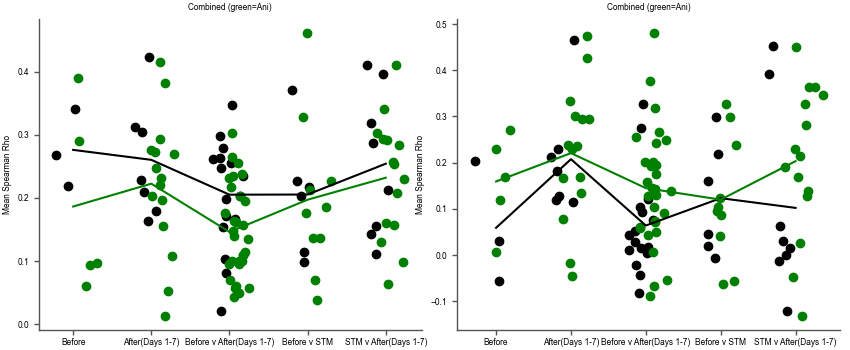

In [12]:
# Scatterplot for each group independently
group_desig = 1  # 1 = include days 1,2, AND 7 in after shock group, 2 = include days 1 and 2 only

figc, axc = plt.subplots(1,2)
figc.set_size_inches((8.5, 3.5))
for arena, a in zip(['Shock', 'Open'], axc):
    _, cont_corr_sm_mean_all, _, _ = pfs.get_group_pf_corrs(err.nonlearners, arena, arena, days, 
                                                            batch_map_use=True, print_to_screen=False)
    _, ani_corr_sm_mean_all, _, _ = pfs.get_group_pf_corrs(err.ani_mice_good, arena, arena, days, 
                                                           batch_map_use=True, print_to_screen=False)

    # Combined scatterplot
    pfs.plot_pfcorr_bygroup(cont_corr_sm_mean_all, arena, arena, '', ax_use=a,
                            color='k', offset=-0.1, save_fig=False, group_desig=group_desig)
    pfs.plot_pfcorr_bygroup(ani_corr_sm_mean_all, arena, arena, 'Combined (green=Ani)',
                        color='g', offset=0.1, ax_use=a, group_desig=group_desig, best_rot=False)

Missing pf files for Marble06 Open Day -2 to Open Day 7
Missing pf files for Marble06 Open Day -1 to Open Day 7
Missing pf files for Marble06 Open Day 4 to Open Day 7
Missing pf files for Marble06 Open Day 1 to Open Day 7
Missing pf files for Marble06 Open Day 2 to Open Day 7
Missing pf files for Marble06 Shock Day -2 to Shock Day 7
Missing pf files for Marble06 Shock Day -1 to Shock Day 7
Missing pf files for Marble06 Shock Day 4 to Shock Day 7
Missing pf files for Marble06 Shock Day 1 to Shock Day 7
Missing pf files for Marble06 Shock Day 2 to Shock Day 7


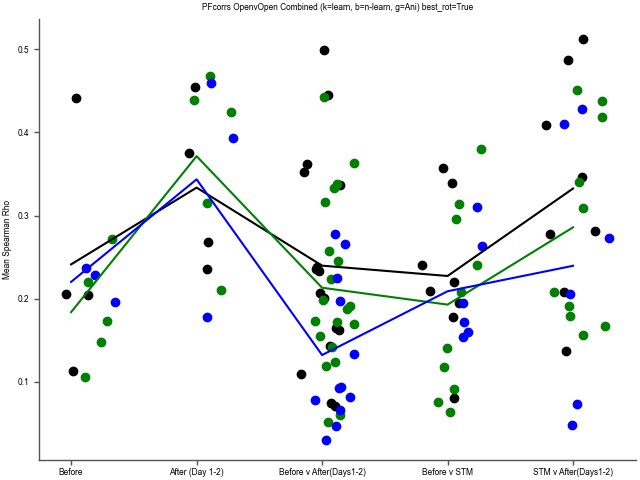

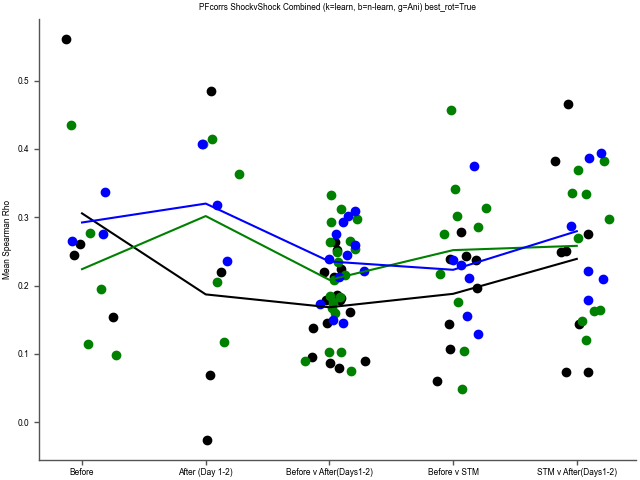

In [13]:
# Need to run this to set up plots - I'm sure there is a better way...
amice = err.ani_mice_good
lmice = err.learners
nlmice = err.nonlearners
days = [-2, -1, 4, 1, 2, 7]
group_desig = 2

corr_type = 'PF'  # 'PV1dboth' or 'PV1dall' or 'PF' are valid options
best_rot = True  # perform PFcorrs at best rotation between session if True, False = no rotation

learn_bestcorr_mean_all = []
nlearn_bestcorr_mean_all = []
ani_bestcorr_mean_all = []

for ida, arena in enumerate(['Open', 'Shock']):
    arena1 = arena
    arena2 = arena
    if corr_type == 'PF':
        _, templ, _, _ = pfs.get_group_pf_corrs(lmice, arena1, arena2, days, best_rot=best_rot, print_to_screen=False)
        _, tempnl, _, _ = pfs.get_group_pf_corrs(nlmice, arena1, arena2, days, best_rot=best_rot, print_to_screen=False)
        _, tempa, _, _ = pfs.get_group_pf_corrs(amice, arena1, arena2, days, best_rot=best_rot, print_to_screen=False)
        prefix = 'PFcorrs'
    elif corr_type == 'PV1dboth':
        _, templ, _, _ = pfs.get_group_PV1d_corrs(lmice, arena1, arena2, days)
        _, tempnl, _, _ = pfs.get_group_PV1d_corrs(nlmice, arena1, arena2, days)
        _, tempa, _, _ = pfs.get_group_PV1d_corrs(amice, arena1, arena2, days)
        prefix = 'PV1dcorrs_both'
    elif corr_type == 'PV1dall':
        templ, _, _, _ = pfs.get_group_PV1d_corrs(lmice, arena1, arena2, days)
        tempnl, _, _, _ = pfs.get_group_PV1d_corrs(nlmice, arena1, arena2, days)
        tempa, _, _, _ = pfs.get_group_PV1d_corrs(amice, arena1, arena2, days)
        prefix = 'PV1dcorrs_all'

    learn_bestcorr_mean_all.append(templ)
    nlearn_bestcorr_mean_all.append(tempnl)
    ani_bestcorr_mean_all.append(tempa)

    #  Combined scatterplots
    figc, axc, _, _, _ = pfs.plot_pfcorr_bygroup(learn_bestcorr_mean_all[ida], arena1, arena2, '', prefix=prefix,
                                        color='k', offset=0, save_fig=False, group_desig=group_desig)
    pfs.plot_pfcorr_bygroup(ani_bestcorr_mean_all[ida], arena1, arena2, '', prefix=prefix,
                            color='g', offset=0.1, ax_use=axc, group_desig=group_desig, save_fig=False)
    pfs.plot_pfcorr_bygroup(nlearn_bestcorr_mean_all[ida], arena1, arena2,
                            prefix + ' ' + arena1 + 'v' + arena2 + ' Combined (k=learn, b=n-learn, g=Ani) best_rot=' + str(best_rot), prefix=prefix,
                            color='b', offset=0.1, ax_use=axc, group_desig=group_desig, save_fig=True, best_rot=best_rot)

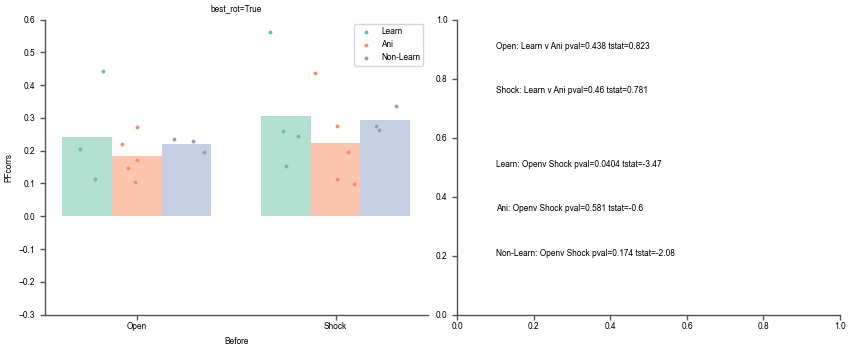

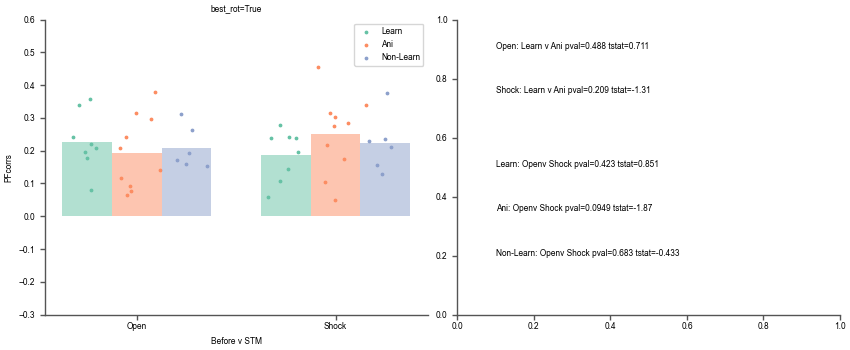

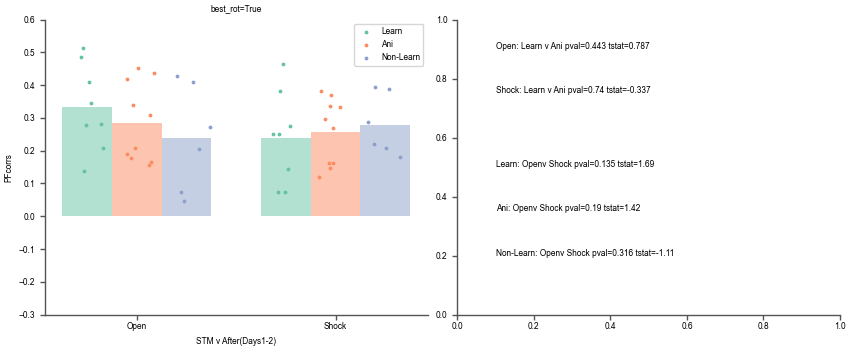

In [14]:
fig_bef, ax_bef = plt.subplots(1, 2)  # supplemental later
ax_aft, ax_aft_stats = Fig2comb.subplot(447) # after axes 
ax_ba, ax_ba_stats = Fig2comb.subplot(446) # before-after axes
fig_bstm, ax_bstm = plt.subplots(1, 2)  # supplemental later
fig_stma, ax_stma = plt.subplots(1, 2)  # supplemental later
[f.set_size_inches((8.5, 3.5)) for f in [fig_bef, fig_bstm, fig_stma]]  # resize plots

# plotting params for consistency
match_yaxis = True
match_ylims = [-0.3, 0.6]
point_size = 3
lgroups, group_labels = pfs.get_time_epochs(len(err.learners), group_desig)
agroups, _ = pfs.get_time_epochs(len(err.ani_mice_good), group_desig)
nlgroups, _ = pfs.get_time_epochs(len(err.nonlearners), group_desig)
for idg, (group, ax) in enumerate(zip(np.unique(lgroups[~np.isnan(lgroups)]).tolist(), 
                                     [ax_bef, [ax_aft, ax_aft_stats], [ax_ba, ax_ba_stats], ax_bstm, ax_stma])):
    open_corrs1 = learn_bestcorr_mean_all[0][lgroups == group]
    shock_corrs1 = learn_bestcorr_mean_all[1][lgroups == group]
    open_corrs2 = ani_bestcorr_mean_all[0][agroups == group]
    shock_corrs2 = ani_bestcorr_mean_all[1][agroups == group]
    open_corrs3 = nlearn_bestcorr_mean_all[0][nlgroups == group]
    shock_corrs3 = nlearn_bestcorr_mean_all[1][nlgroups == group]


    fig_, ax_, pval, tstat = erp.pfcorr_compare([open_corrs1, open_corrs2, open_corrs3], 
                                                [shock_corrs1, shock_corrs2, shock_corrs3],
                                                group_names=['Learn', 'Ani', 'Non-Learn'], xlabel=group_labels[idg], 
                                                ylabel=prefix, xticklabels=['Open', 'Shock'], 
                                                ax=ax, s=point_size)

    if corr_type == 'PF':
        if not match_yaxis:
            pass
#             savefile = os.path.join(plot_dir, prefix + ' 2x2 All groups best_rot=' + str(best_rot) + ' ' +
#                                     group_labels[idg] +' .pdf')
        elif match_yaxis:
            ax[0].set_ylim(match_ylims)
#             savefile = os.path.join(plot_dir, prefix + ' 2x2 All Groups best_rot=' + str(best_rot) + ' ' +
#                                     group_labels[idg] +'_equalaxes.pdf')

        ax[0].set_title('best_rot=' + str(best_rot))
    else:
        pass
#         savefile = os.path.join(plot_dir, prefix + ' 2x2 All Groups ' + group_labels[idg] + '.pdf')
#     fig.savefig(savefile)

## NRK todo: implement 2-way ANOVA (group and arena) for above plots
https://www.statology.org/two-way-anova-python/ should be helpful